In [5]:
import sys
import pickle
import matplotlib.pyplot as plt

### PanelB & PanelC

#### download validation data:
* wget https://public.gi.ucsc.edu/brookslab/addseq/231205_valdata_pred_out.pkl

In [7]:
pred_out = '231205_valdata_pred_out.pkl'
with open(pred_out, 'rb') as pred_outf:
    seq_preds = pickle.load(pred_outf)
print("Loaded Python object:", seq_preds)

In [1]:
print('computing accuracy...')
correct = {0: 0, 1: 0}
total = {0: 0, 1: 0}

for seq_id in tqdm(seq_preds):
    label = seq_id[0]
    pred_arr = np.round(np.array(seq_preds[seq_id]))
    if label == 0:
        label_arr = np.zeros(len(pred_arr))
    else:
        label_arr = np.ones(len(pred_arr))
    correct_arr = (pred_arr == label_arr)
    correct[label] += np.sum(correct_arr)
    total[label] += len(pred_arr)

accuracy = (correct[0] + correct[1]) / float(total[0] + total[1])  

true_negatives = correct[0]
true_positives = correct[1]
false_negatives = total[1] - correct[1]
false_positives = total[0] - correct[0]

precision = true_positives / float(true_positives + false_positives)
recall = true_positives / float(true_positives + false_negatives)

print("True negatives:", true_negatives)
print("True positives:", true_positives)
print("False negatives:", false_negatives)
print("False positives:", false_positives)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


In [ ]:
# Plot prediction mean and std for each validation sequence
seq_means = {0: [], 1: []}
seq_stds = {0: [], 1: []}
for seq_id in tqdm(seq_preds):
    label = seq_id[0]
    seq_means[label].append(np.mean(seq_preds[seq_id]))
    seq_stds[label].append(np.std(seq_preds[seq_id]))
fig = plt.figure(figsize=(5,4))
plt.scatter(seq_means[0], seq_stds[0], label='negative')
plt.scatter(seq_means[1], seq_stds[1], label='positive')
plt.legend()
plt.xlabel('Prediction Mean')
plt.ylabel('Prediction Std')
plt.show()
plt.savefig('/private/groups/brookslab/gabai/projects/addseq_manuscript/figures/Figure4_resnet1d_val_mean_std.pdf', dpi = 1000)
plt.close()

print('Plot accuracy by sequence length for each sequence in validation set...')
seq_lens = {0: [], 1: []}
seq_accs = {0: [], 1: []}
for seq_id in tqdm(seq_preds):
    seq_len = len(seq_preds[seq_id])
    label = seq_id[0]
    if label == 0:
        label_arr = np.zeros(seq_len)
    else:
        label_arr = np.ones(seq_len)
    pred_arr = np.round(np.array(seq_preds[seq_id]))
    correct_arr = (pred_arr == label_arr)
    correct = np.sum(correct_arr)
    seq_acc = float(correct) / seq_len
    seq_lens[label].append(seq_len)
    seq_accs[label].append(seq_acc)
fig = plt.figure(figsize=(5,4))
plt.scatter(seq_lens[0], seq_accs[0], label='negative')
plt.scatter(seq_lens[1], seq_accs[1], label='positive')
plt.legend()
plt.xlabel('Sequence Length')
plt.ylabel('Sequence Accuracy')
plt.savefig('/private/groups/brookslab/gabai/projects/addseq_manuscript/figures/Figure4_resnet1d_val_accurracy_vs_seqlen.pdf', dpi = 1000)
plt.close()

# Compute ROC curve
print('computing roc...')
pred_list = []
label_list = []
for seq_id in tqdm(seq_preds):
    seq_len = len(seq_preds[seq_id])
    label = seq_id[0]
    preds = seq_preds[seq_id]
    if label == 0:
        labels = np.zeros(seq_len)
    else:
        labels = np.ones(seq_len)
    pred_list.append(preds)
    label_list.append(labels)
    
pred_cat = np.concatenate(pred_list)
label_cat = np.concatenate(label_list)

fpr, tpr, thresholds = roc_curve(label_cat, pred_cat)
roc_auc = auc(fpr, tpr)
fig = plt.figure(figsize=(5,4))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.plot(fpr, tpr, color="darkorange", lw=2,
        label="AUC = %0.2f" % roc_auc)
plt.title("Receiver operating characteristic (ROC)", size = 'medium')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.savefig('/private/groups/brookslab/gabai/projects/addseq_manuscript/figures/Figure4_resnet1d_val_roc.pdf', dpi = 1000)
plt.close()
print('best cutoff:', thresholds[np.argmax(tpr - fpr)])

# Calculate kernel density estimate
pos_reads = []
neg_reads = []
for seq_id in tqdm(seq_preds):
    label = seq_id[0]
    if label == 0:
        neg_reads += seq_preds[seq_id]
    else:
        pos_reads += seq_preds[seq_id]
pos_kde = gaussian_kde(pos_reads)
neg_kde = gaussian_kde(neg_reads)
# Create a range of values for x-axis
pos_values = np.linspace(-0.01,1.01, 100)
neg_values = np.linspace(-0.01,1.01, 100)
# Plot the density curve
fig = plt.figure(figsize=(5,4))
plt.plot(pos_values, pos_kde(pos_values), label='Pos Ctrl')
plt.plot(neg_values, neg_kde(neg_values), label='Neg Ctrl')
# Add labels and title
plt.xlabel('Predicted scores')
plt.ylabel('Density')
plt.title('Density of predicted scores')
# Show legend
plt.legend()
# Show the plot
plt.savefig('/private/groups/brookslab/gabai/projects/addseq_manuscript/figures/Figure4_resnet1d_val_density.pdf', dpi = 1000)
plt.close()

### Panel E

In [1]:
import sys
sys.path.insert(0, '/private/groups/brookslab/gabai/tools/NEMO/src/')
from plotUtil import *

In [4]:
cln2_pred  = '../data/240116_resnetv1_CLN2_step20_chrXVI:66000-67600_all_prediction.tsv'
gtfFile = '../data/Saccharomyces_cerevisiae.R64-1-1.109.gtf'
region = 'chrXVI:66000-67600'
pregion = 'chrXVI:66400-67550'
step = 20
chrom = region.split(':')[0]
qstart, qend = int(region.split(':')[1].split('-')[0]), int(region.split(':')[1].split('-')[1])
bins = np.arange(qstart, qend, step)

Start clustering reads...
preprocessing input matrix...
writing output to file:  ../figures/Figure4_resnetv1_CLN2_3_clusters_seed42_step20_chrXVI:66400-67550.mtx
Clustering with number of clusters = 3
Finished clustering reads!
Figure size: 6 4
plotting gene annotations...
Here~~


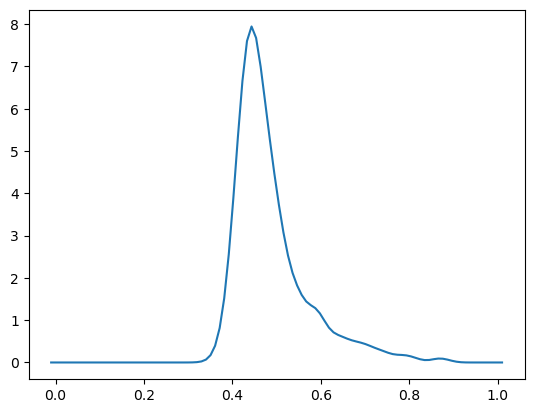

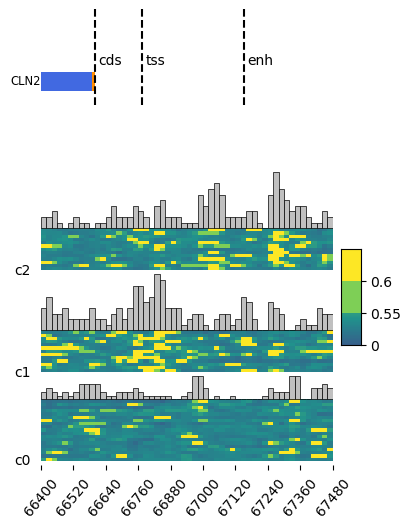

In [38]:
plotAllTrack(cln2_pred, gtfFile, outpath = '../figures/', 
             prefix ='Figure4_resnetv1_CLN2_3_clusters_seed42_step20', bins = bins, region = region, seed=42,
             pregion = pregion, method = '', step=20, vlines = {'tss':66800, 'enh': 67200, 'cds': 66614},
             ncluster = 3, savefig = True, trackHeight = 0.8, colorRange=(0.3, 0.55, 0.6), fig_size=(6,4), track_ylim_adjust=10)

### PanelF & PanelG

In [40]:
import importlib
importlib.reload(sys.modules['plotUtil'])
from plotUtil import *

#### Mnase-seq data

In [42]:
xval, yval = plotAggregate_nuc(pred = '../data/ref/sacCer3.bedgraph', 
                  outpath = '../figures/', space=150,
                  prefix = 'Figure4_mnase_150_tss', labels = ('distance to tss (bp)', 'mnase-seq peak'),
                  bed = '../data/ref/allTSS.bed', window=4000, sw=10, col = {'chrom':0, 'start':1, 'end':2, 'strand':5})

xval0, yval0 =plotAggregate_nuc(pred = '../data/ref/sacCer3.bedgraph', 
                  outpath = '../figures/', space=150, end = True,
                  prefix = 'Figure4_mnase_150_tts',  labels = ('distance to tts (bp)', 'mnase-seq peak'),
                  bed = '../data/ref/allCES.bed', window=4000, sw=10, col = {'chrom':0, 'start':1, 'end':2, 'strand':4})

#### Add-seq data

In [ ]:
xval2, yval2 = plotAggregate(pred = '../data/resnetv1_all_prediction.tsv', outpath = '../figures/', 
                            prefix = 'Figure4_addseq_tss_150_sw20',  space=150, thred = "",
                            bed = '../data/ref/allTSS.bed', window =4000, sw=20, col = {'chrom':0, 'start':1, 'end':2, 'strand':5})

xval22, yval22 = plotAggregate(pred = '../data/resnetv1_all_prediction.tsv', outpath = '../figures/', 
              prefix = 'Figure4_addseq_tts_150_sw20',  space=150, thred = "", end = True,
              labels = ('distance to tts (bp)', 'prediction score'),
              bed = '../data/ref/allCES.bed', window = 4000, sw=20, col = {'chrom':0, 'start':1, 'end':2, 'strand':4})

### Concat two plots

In [ ]:
halfwindow = 2000
space = 150
f, (ax1, ax2) = plt.subplots(2, sharex='all', gridspec_kw={'height_ratios': [3, 2]}, figsize=(6,4), layout="constrained")

color = 'tab:orange'
ax1.set_ylabel('prediction score', color='black')
ax1.plot(xval2, yval2, color=color, label = 'Add-seq')
ax1.grid(alpha=0.8, axis = 'x')
ax1.legend()
color = 'tab:blue'
ax2.set_ylabel('score', color='black')  # we already handled the x-label with ax1
ax2.plot(xval, yval, color=color, label = 'mnase-seq')
ax2.set_xlabel('distance to tss (bp)')
ax2.set_xticks(np.concatenate((np.flip(np.arange(0, -halfwindow-1, -space)[1:]), np.arange(0, halfwindow+1, space)), axis=0))
ax2.grid(alpha=0.8, axis = 'x')
ax2.legend()


plt.xticks( rotation='vertical')
plt.subplots_adjust(hspace=.03)
plt.savefig('../figures/Figure4F_tss_mnaseq_addseq_one_plot.pdf', dpi = 200)


halfwindow = 2000
space = 150

f, (ax1, ax2) = plt.subplots(2, sharex='all', gridspec_kw={'height_ratios': [3, 2]}, figsize=(6,4), layout="constrained")
color = 'tab:orange'
ax1.set_ylabel('prediction score', color='black')
ax1.plot(xval22, yval22, color=color, label = 'Add-seq')
ax1.grid(alpha=0.8, axis = 'x')
ax1.legend()
color = 'tab:blue'
ax2.set_ylabel('score', color='black')  # we already handled the x-label with ax1
ax2.plot(xval0, yval0, color=color, label = 'mnase-seq')
ax2.set_xlabel('distance to tts (bp)')
ax2.set_xticks(np.concatenate((np.flip(np.arange(0, -halfwindow-1, -space)[1:]), np.arange(0, halfwindow+1, space)), axis=0))
ax2.grid(alpha=0.8, axis = 'x')
ax2.legend()


plt.xticks( rotation='vertical')
# plt.subplots_adjust(hspace=.03)
plt.savefig('../figures/Figure4G_tts_mnaseq_addseq_one_plot.pdf', dpi = 200)